<a href="https://colab.research.google.com/github/JiayuShen0912/Week3-Machine_Learning/blob/Jiayu_Shen/Jiayu_Shen_Week_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [166]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


At first, I import the required libraries.

In [167]:
#importing the required libraries

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import librosa.display
import soundfile
import os
# matplotlib complains about the behaviour of librosa.display, so we'll ignore those warnings:
import warnings; warnings.filterwarnings('ignore')

Similar to the tutorial in Week 3, I perform audio data classification utilizing different machine learning models (as done in the tutorial) on the combined dataset (created in the previous assignment).

# Feature Extraction

The tutorial in Week 3 make full use of librosa, a Python library that supports audio analysis and feature extraction. Librosa abstracts away all the math and most of the details of mel spectrorgams, chromagrams, and MFCC. And the Mel Spectrogram, MFCC, and chromagrams of each audio file are taken as separate features to try and have bit more discriminatory power between samples.

As in the tutorial, I will build feature extraction functions to get a chromagram, a mel spectorgram, and MFC coefficients for each of audio files in merged RAVDESS dataset. Because the chromagram, mel spectrogram and MFCCs are calculated on audio frames produced by STFT, I’m going to get a matrix back from each function, so I’ll take the mean of those matrices to produce a single feature array for each feature and each audio sample, i.e. 3 feature arrays per audio sample.

**Chromagram**: Will produce 12 features; One for each of 12 pitch classes

**Mel Spectrogram**: Will produce 128 features; We've defined the number of mel frequency bands at n_mels=128

**MFCC**: Will produce 40 MFCCs; I've set the number of coefficients to return at n_mfcc=40

In [168]:
def feature_chromagram(waveform, sample_rate):
    # STFT computed here explicitly; mel spectrogram and MFCC functions do this under the hood
    stft_spectrogram=np.abs(librosa.stft(waveform))
    # Produce the chromagram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    chromagram=np.mean(librosa.feature.chroma_stft(S=stft_spectrogram, sr=sample_rate).T,axis=0)
    return chromagram

def feature_melspectrogram(waveform, sample_rate):
    # Produce the mel spectrogram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # Using 8khz as upper frequency bound should be enough for most speech classification tasks
    melspectrogram=np.mean(librosa.feature.melspectrogram(y=waveform, sr=sample_rate, n_mels=128, fmax=8000).T,axis=0)
    return melspectrogram

def feature_mfcc(waveform, sample_rate):
    # Compute the MFCCs for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # 40 filterbanks = 40 coefficients
    mfc_coefficients=np.mean(librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=40).T, axis=0)
    return mfc_coefficients

In [169]:
def get_features(file):
    # load an individual soundfile
     with soundfile.SoundFile(file) as audio:
        waveform = audio.read(dtype="float32")
        sample_rate = audio.samplerate
        # compute features of soundfile
        chromagram = feature_chromagram(waveform, sample_rate)
        melspectrogram = feature_melspectrogram(waveform, sample_rate)
        mfc_coefficients = feature_mfcc(waveform, sample_rate)

        feature_matrix=np.array([])
        # use np.hstack to stack our feature arrays horizontally to create a feature matrix
        feature_matrix = np.hstack((chromagram, melspectrogram, mfc_coefficients))

        return feature_matrix

# Load the Dataset and Compute Features

In [170]:
#Emotions in the merged RAVDESS dataset
emotions ={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

Load entire merged RAVDESS dataset and compute the features of each audio file:

In [171]:
import os, glob

def load_data():
    X,y=[],[]
    count = 0
    for file in glob.glob("/content/drive/MyDrive/IAT481/RAVDESS/Actor_*/*.wav"):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        features = get_features(file)
        X.append(features)
        y.append(emotion)
        count += 1
        # '\r' + end='' results in printing over same line
        print('\r' + f' Processed {count}/{1510} audio samples',end=' ')
    # Return arrays to plug into sklearn's cross-validation algorithms
    return np.array(X), np.array(y)

Compute the feature matrix and read the emotion labels for the entire dataset. The regressor (independent/explanatory variable), usually denoted X, is named 'features', andnthe regressand (dependent variable), usually denoted y, is named 'emotions'.

In [172]:
features, emotions = load_data()

 Processed 1508/1510 audio samples 

Let's see what the features we extracted look like, **also for saving both the features matrix as well as emotions array, we need to convert them to pandas dataframe**.

In [173]:
print(f'\nAudio samples represented: {features.shape[0]}')
print(f'Numerical features extracted per sample: {features.shape[1]}')
features_df = pd.DataFrame(features) # make it pretty for display


#making dataframe for emotions as well
emotions_df = pd.DataFrame(emotions) # make it pretty for display

features_df


Audio samples represented: 1508
Numerical features extracted per sample: 180


,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,0.644146,0.656105,0.708153,0.695137,0.686821,0.712302,0.727069,0.696747,0.650816,0.612729,...,2.607751,3.012774,3.111278,2.720025,3.630754,2.887563,1.661354,0.819504,1.513862,1.587056
1,0.625559,0.617114,0.661715,0.704667,0.707384,0.732726,0.753858,0.743932,0.706780,0.658062,...,0.309918,0.995247,3.098048,3.447319,3.925992,3.524065,2.546757,0.801444,0.829698,2.993000
2,0.583587,0.607044,0.636328,0.623497,0.615004,0.621348,0.662038,0.737869,0.726401,0.655718,...,3.916962,3.535635,1.121832,1.980238,3.663332,3.633737,2.196083,2.075861,1.634632,2.395831
3,0.550681,0.534769,0.493836,0.503581,0.559845,0.653748,0.733878,0.789869,0.765729,0.642379,...,1.370107,1.758198,1.797105,0.867151,1.723282,1.673261,0.854336,0.491017,0.694623,2.991599
4,0.601642,0.617534,0.665111,0.690098,0.711811,0.743393,0.746468,0.811313,0.819656,0.768950,...,-1.931422,0.705211,-1.421736,0.109918,0.826748,3.198303,3.540084,4.285282,5.466786,6.817317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1503,0.512651,0.486514,0.461302,0.508587,0.560068,0.484810,0.444028,0.457924,0.553169,0.573116,...,5.759862,6.355183,-1.343105,3.267918,2.497807,5.027735,2.651696,5.945119,0.777430,1.573013
1504,0.671552,0.672361,0.721524,0.796471,0.820246,0.800492,0.718540,0.665389,0.675278,0.671041,...,0.501173,0.750682,1.155867,2.139405,2.853925,4.503895,4.369723,5.673851,3.814040,3.972134
1505,0.465606,0.412895,0.470289,0.543011,0.545508,0.543211,0.522467,0.606573,0.639784,0.545700,...,7.082125,6.705487,2.212559,2.411969,0.835325,3.989799,3.049524,2.829816,-1.029237,1.390248
1506,0.495226,0.458357,0.447500,0.480542,0.480229,0.532152,0.600867,0.531699,0.533897,0.568107,...,5.743650,5.726628,3.702856,6.953134,3.173564,4.104837,1.698271,-0.328703,-4.103455,-0.273010


I have a matrix of dim 1508 x 180. 1508 audio samples, one per row, with a series of 180 numerical features for each sample.

**Each of the 1508 feature arrays has 180 features composed of 12 chromagram pitch classes + 128 mel spectrogram bands + 40 MFC coefficients.**

Now I will save our features matrix and emotions array in excel file I dont have to compute them everytime I run the notebook, I can just load them from the excel file whenever required.

In [174]:
features_df.to_excel('/content/drive/MyDrive/IAT481/featuresRavdess.xlsx')
emotions_df.to_excel('/content/drive/MyDrive/IAT481/emotionsRavdess.xlsx')

# Load pre-saved Dataset

Once saved I only need to load them later by running the cell below, and skip every cell above except for the one in which I import libraries.

In [175]:
features=pd.read_excel('/content/drive/MyDrive/IAT481/featuresRavdess.xlsx',index_col=0)
emotions=pd.read_excel('/content/drive/MyDrive/IAT481/emotionsRavdess.xlsx',index_col=0)

Let's see if they have been loaded correctly!

In [176]:
features.head()

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,0.644146,0.656105,0.708153,0.695137,0.686821,0.712302,0.727069,0.696747,0.650816,0.612729,...,2.607751,3.012774,3.111278,2.720025,3.630754,2.887563,1.661354,0.819504,1.513862,1.587056
1,0.625559,0.617114,0.661715,0.704667,0.707384,0.732726,0.753858,0.743932,0.706780,0.658062,...,0.309918,0.995247,3.098048,3.447319,3.925992,3.524065,2.546757,0.801444,0.829698,2.993000
2,0.583587,0.607044,0.636328,0.623497,0.615004,0.621348,0.662038,0.737869,0.726401,0.655718,...,3.916962,3.535635,1.121832,1.980238,3.663332,3.633737,2.196083,2.075861,1.634632,2.395831
3,0.550681,0.534769,0.493836,0.503581,0.559845,0.653748,0.733878,0.789869,0.765729,0.642379,...,1.370107,1.758198,1.797105,0.867151,1.723282,1.673261,0.854336,0.491017,0.694623,2.991599
4,0.601642,0.617534,0.665111,0.690098,0.711811,0.743393,0.746468,0.811313,0.819656,0.768950,...,-1.931422,0.705211,-1.421736,0.109918,0.826748,3.198303,3.540084,4.285282,5.466786,6.817317


In [177]:
emotions.head()

,0
0,angry
1,angry
2,fearful
3,fearful
4,sad


Let's see the class balance of merged RAVDESS dataset:

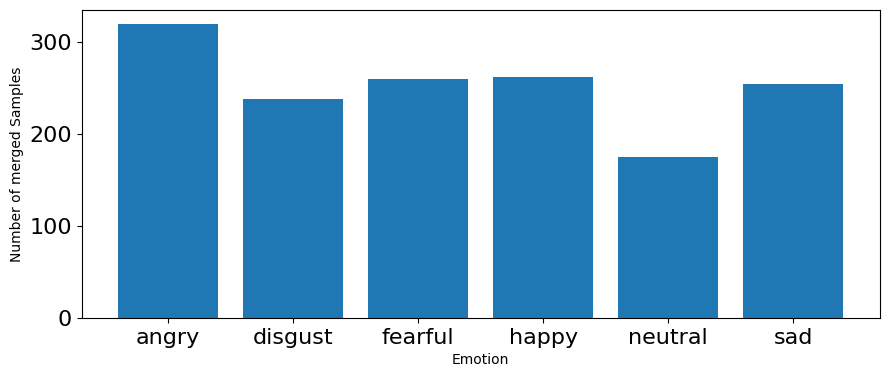

In [178]:
# plot emotions
plt.figure(figsize=(35,4))
plt.subplot(1,3,2)
emotion_list, count = np.unique(emotions, return_counts=True)
plt.bar(x=range(6), height=count)
plt.xticks(ticks=range(6), labels = [emotion for emotion in emotion_list],fontsize=10)
plt.xlabel('Emotion')
plt.tick_params(labelsize=16)
plt.ylabel('Number of merged Samples')
plt.show()

# Feature Scaling

To properly perform audio data classification utilizing different machine learning models, I first need to scale features.

In [179]:
# We would usually use df.describe(), but it provides a bit of a mess of information we don't need at the moment.
def print_features(df):
    # Check chromagram feature values
    features_df_chromagram = df.loc[:,:11]
    chroma_min = features_df_chromagram.min().min()
    chroma_max = features_df_chromagram.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    chroma_mean = features_df_chromagram.stack().mean()
    chroma_stdev = features_df_chromagram.stack().std()
    print(f'12 Chromagram features:       \
    min = {chroma_min:.3f}, \
    max = {chroma_max:.3f}, \
    mean = {chroma_mean:.3f}, \
    deviation = {chroma_stdev:.3f}')

    # Check mel spectrogram feature values
    features_df_melspectrogram = df.loc[:,12:139]
    mel_min = features_df_melspectrogram.min().min()
    mel_max = features_df_melspectrogram.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    mel_mean = features_df_melspectrogram.stack().mean()
    mel_stdev = features_df_melspectrogram.stack().std()
    print(f'\n128 Mel Spectrogram features: \
    min = {mel_min:.3f}, \
    max = {mel_max:.3f}, \
    mean = {mel_mean:.3f}, \
    deviation = {mel_stdev:.3f}')

    # Check MFCC feature values
    features_df_mfcc = df.loc[:,140:179]
    mfcc_min = features_df_mfcc.min().min()
    mfcc_max = features_df_mfcc.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    mfcc_mean = features_df_mfcc.stack().mean()
    mfcc_stdev = features_df_mfcc.stack().std()
    print(f'\n40 MFCC features:             \
    min = {mfcc_min:.3f},\
    max = {mfcc_max:.3f},\
    mean = {mfcc_mean:.3f},\
    deviation = {mfcc_stdev:.3f}')

print_features(features_df)

12 Chromagram features:           min = 0.276,     max = 0.888,     mean = 0.640,     deviation = 0.093

128 Mel Spectrogram features:     min = 0.000,     max = 886.647,     mean = 1.328,     deviation = 9.748

40 MFCC features:                 min = -863.639,    max = 121.174,    mean = -11.163,    deviation = 82.575


To properly perform audio data classification utilizing different machine learning models, I first need to scale features. As in the tutorial, I chose sklearn’s **StandardScaler** and **MinMaxScaler** to scale the features of the combined RAVDESS dataset. Standard scaling subtracts the mean of each feature and then divides by the standard deviation of that feature to get a mean of 0 and the features of the unit variance, i.e. the variance and standard deviation, of 1. Min-Max scaling converts each feature into a specified bounded interval.

In practice, minimum scaling is particularly useful when it is known that the feature should be within a bounded interval, such as the pixel values in [0,255], while standard scaling may be more practical for features with unknown distributions, because concentrating the feature at zero mean with a standard deviation of 1 means that the extreme value will have a smaller impact on the model's learning weight, i.e. the model is less sensitive to outliers.

In [180]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
# keep our unscaled features just in case we need to process them alternatively
features_scaled = features
features_scaled = scaler.fit_transform(features_scaled)

scaler = MinMaxScaler()
# keep our unscaled features just in case we need to process them alternatively
features_minmax = features
features_minmax = scaler.fit_transform(features_minmax)

Make sure our features are properly scaled:

In [181]:
print('\033[1m'+'Standard Scaling:\n'+'\033[0m')
features_scaled_df = pd.DataFrame(features_scaled)
print_features(features_scaled_df)

print('\n\n\033[1m'+'MinMax Scaling:\n'+'\033[0m')
features_minmax_df = pd.DataFrame(features_minmax)
print_features(features_minmax_df)

Standard Scaling:

12 Chromagram features:           min = -4.046,     max = 2.602,     mean = 0.000,     deviation = 1.000

128 Mel Spectrogram features:     min = -0.475,     max = 33.092,     mean = -0.000,     deviation = 1.000

40 MFCC features:                 min = -4.719,    max = 6.582,    mean = 0.000,    deviation = 1.000


MinMax Scaling:

12 Chromagram features:           min = 0.000,     max = 1.000,     mean = 0.599,     deviation = 0.179

128 Mel Spectrogram features:     min = 0.000,     max = 1.000,     mean = 0.024,     deviation = 0.068

40 MFCC features:                 min = 0.000,    max = 1.000,    mean = 0.393,    deviation = 0.177


Zero mean and unit variance for standard scaling and in the range [0,1] for MinMax scaling - a default when we don't specify values. We can now move on to building predictive models for these features.

# Classical Machine Learning Models

# Training: The 80/20 Split and Validation








I'll use sklearn's train_test_split to create a standard 80/20 train/test split. The model is fit on 80% of the data and tested for performance against 20% of the data, which it has never seen in training - also called the hold-out set.

In [182]:
from sklearn.model_selection import train_test_split


############# Unscaled test/train set #############
X_train, X_test, y_train, y_test =train_test_split(
    features,
    emotions,
    test_size=0.2,
    random_state=69
)

############ Standard Scaled test/train set ###########
# The labels/classes (y_train, y_test) never change, keep old values
X_train_scaled, X_test_scaled, _, _ = train_test_split(
    features_scaled,
    emotions,
    test_size=0.2,
    random_state=69
)

############# MinMax Scaled test/train set ###############
# The labels/classes (y_train, y_test) never change, keep old values
X_train_minmax, X_test_minmax, _, _ = train_test_split(
    features_scaled,
    emotions,
    test_size=0.2,
    random_state=69
)

# Comparing Models

I'll try each off-the-shelf machine learning model from sklearn, and compare the accuracy score of different models.

In [183]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classification_models = [
    KNeighborsClassifier(),#(3),
    SVC(kernel='linear'),#, C=0.025),
    SVC(kernel='rbf'),
    DecisionTreeClassifier(),#max_depth=5),
    RandomForestClassifier(),#max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

scores = []
for model in classification_models:
    model.fit(X_train_scaled, y_train)
    score = model.score(X_test_scaled, y_test)
    model_name = type(model).__name__
    if model_name=='SVC' and model.kernel=='rbf': model_name+=' RBF kernel'
    scores.append((model_name,(f'{100*score:.2f}%')))
# Make it pretty
scores_df = pd.DataFrame(scores,columns=['Classifier','Accuracy Score'])
scores_df.sort_values(by='Accuracy Score',axis=0,ascending=False)

,Classifier,Accuracy Score
1,SVC,62.91%
4,RandomForestClassifier,60.93%
2,SVC RBF kernel,54.30%
0,KNeighborsClassifier,51.99%
3,DecisionTreeClassifier,45.03%
6,GaussianNB,32.12%
5,AdaBoostClassifier,30.79%
7,QuadraticDiscriminantAnalysis,28.15%


from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('Classifier').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('Accuracy Score').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Accuracy Score'].value_counts()
    for x_label, grp in _df_5.groupby('Classifier')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Classifier')
_ = plt.ylabel('Accuracy Score')

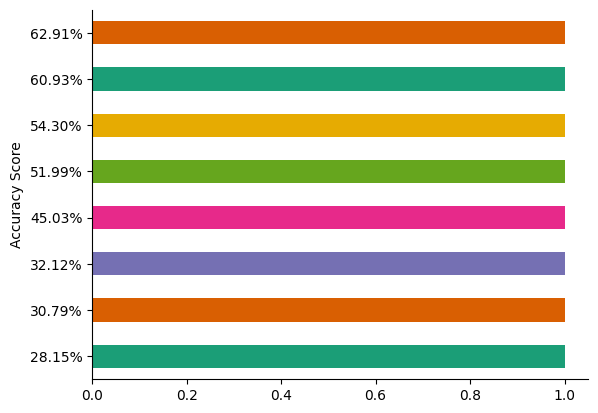

In [185]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('Accuracy Score').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

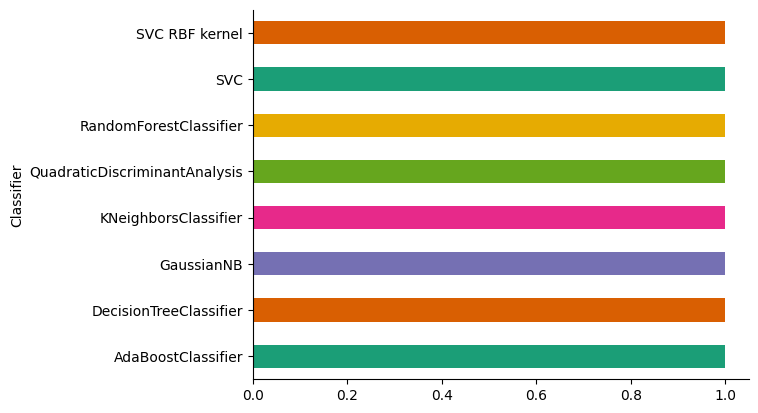

In [186]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('Classifier').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

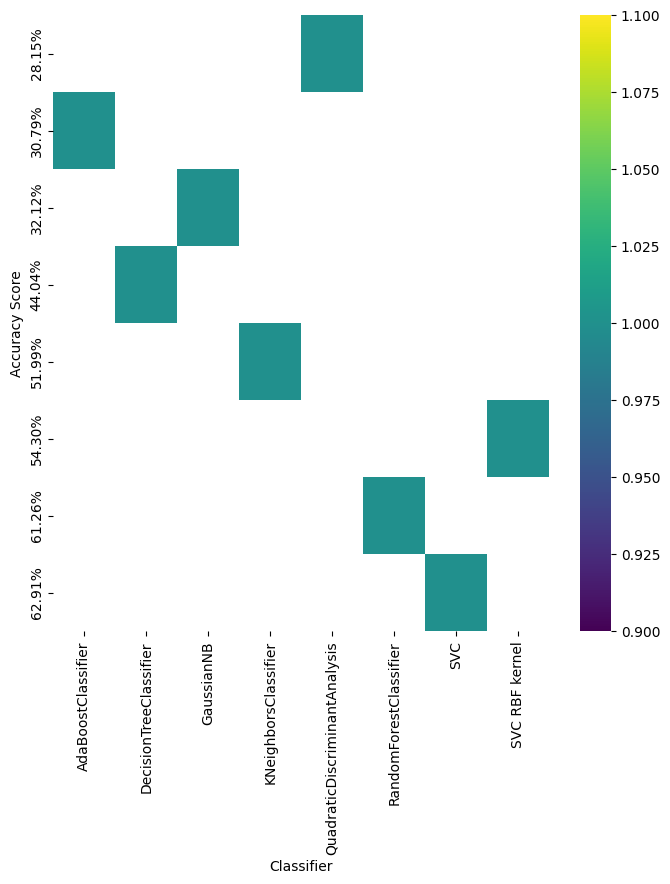

In [165]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Accuracy Score'].value_counts()
    for x_label, grp in _df_2.groupby('Classifier')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Classifier')
_ = plt.ylabel('Accuracy Score')

From the plot, we can see that the accuracy scores of different models vary greatly. For the combined RAVDESS dataset, SVC performs the best, with an accuracy score of 62.91%, while QuadraticDiscriminantAnalysis performs the worst, with an accuracy of 28.15%. The mean accuracy score of the eight models is about 50%.

Let's pick the Random Forests, SVC, and kNN - and take a closer look at each of them.

# The Support Vector Machine Classifier

In [187]:
from sklearn.svm import SVC

model = SVC(
    C=10,  #higher the value tighter the margin
    gamma='auto',
    kernel='rbf',
    random_state=69
)

model.fit(X_train, y_train)

print(f'SVC Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'SVC Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%')

SVC Model's accuracy on training set is 100.00%
SVC Model's accuracy on test set is 39.40%


# k Nearest Neighbours

In [189]:
from sklearn.neighbors import KNeighborsClassifier

####### Default kNN  ########
model = KNeighborsClassifier(
)

model.fit(X_train, y_train)

print(f'Default kNN Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'Default kNN Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%\n')

##### (hastily) tuned kNN ######
model = KNeighborsClassifier(
    n_neighbors = 5,
    weights = 'distance',
    algorithm = 'brute',
    n_jobs=4
)

model.fit(X_train, y_train)

print(f'kNN Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'kNN Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%')

Default kNN Model's accuracy on training set is 71.48%
Default kNN Model's accuracy on test set is 45.70%

kNN Model's accuracy on training set is 100.00%
kNN Model's accuracy on test set is 51.99%


# Random Forests

In [190]:
from sklearn.ensemble import RandomForestClassifier

####### Default Random Forest ########
model = RandomForestClassifier(
    random_state=69
)

model.fit(X_train, y_train)

print(f'Default Random Forest Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'Default Random Forest Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%\n')


########## Tuned Random Forest #######
model = RandomForestClassifier(
    n_estimators = 500,
    criterion ='entropy',
    warm_start = True,
    max_features = 'sqrt',
    oob_score = True, # more on this below
    random_state=69
)

model.fit(X_train, y_train)

print(f'Random Forest Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'Random Forest Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%')

Default Random Forest Model's accuracy on training set is 100.00%
Default Random Forest Model's accuracy on test set is 59.27%

Random Forest Model's accuracy on training set is 100.00%
Random Forest Model's accuracy on test set is 63.25%
